In [1]:
# General imports
import numpy as np
import torch

import matplotlib.pyplot as plt
from os import listdir
from natsort import natsorted
import seaborn as sns
sns.set(context='paper', style='white')
%config InlineBackend.figure_format = 'svg'
# DeepMoD stuff
from multitaskpinn import DeepMoD
from multitaskpinn.model.func_approx import NN
from multitaskpinn.model.library import Library1D
from multitaskpinn.model.constraint import LeastSquares
from multitaskpinn.model.sparse_estimators import Threshold
from multitaskpinn.training.sparsity_scheduler import TrainTestPeriodic
from experiment_code import train

from multitaskpinn.data import Dataset
from multitaskpinn.data.kdv import DoubleSoliton

from multitaskpinn.analysis import load_tensorboard



In [2]:
# Settings
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
x = np.linspace(-10, 10, 50)
t = np.linspace(0.0, 2.0, 20)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

dataset = Dataset(DoubleSoliton, c=[5.0, 1.0], x0=[-5.0, -1.0])
X, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.4, random=True, normalize=True)
X, y = X.to(device), y.to(device)

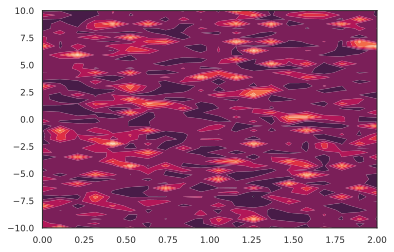

In [6]:
plt.contourf(t_grid, x_grid, y.reshape(x_grid.shape).cpu())

# Running data scaling

In [10]:
# Running for multiple factors
factors = torch.logspace(-2, 2, 5)

for factor in factors:
    sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=5000, delta=1e-4) # in terms of write iterations
    network = NN(2, [30, 30, 30, 30, 30], 1)
    library = Library1D(poly_order=2, diff_order=3) # Library function
    estimator = Threshold(0.1) # Sparse estimator 
    constraint = LeastSquares() # How to constrain
    model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model
    optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True, lr=1e-3) # Defining optimizer
    
    y_train = y * factor
    train(model, X, y_train, optimizer, sparsity_scheduler, exp_ID=f'data_scaling_factor_{factor:.1e}', split=0.8, write_iterations=50, max_iterations=1500, delta=0.0, patience=200) 

  1450  MSE: 2.94e-05  Reg: 2.28e-07  L1: 2.73e+01 Algorithm converged. Writing model to disk.
  1450  MSE: 2.48e-04  Reg: 3.43e-05  L1: 4.81e+00 Algorithm converged. Writing model to disk.
  1450  MSE: 2.32e-02  Reg: 2.15e-03  L1: 5.51e+00 Algorithm converged. Writing model to disk.
  1450  MSE: 1.45e+01  Reg: 1.60e-01  L1: 1.81e+01 Algorithm converged. Writing model to disk.
  1450  MSE: 4.00e+03  Reg: 3.37e-11  L1: 7.43e+05 Algorithm converged. Writing model to disk.


# Running regression scaling

In [11]:
factors = torch.logspace(-4, 4, 20)

for factor in factors:
    sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-4) # in terms of write iterations
    network = NN(2, [30, 30, 30, 30, 30], 1)
    library = Library1D(poly_order=2, diff_order=3) # Library function
    estimator = Threshold(0.1) # Sparse estimator 
    constraint = LeastSquares() # How to constrain
    model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model
    optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True, lr=1e-3) # Defining optimizer
    
    train(model, X, y, optimizer, sparsity_scheduler, lambda_reg=factor, exp_ID=f'reg_scaling_factor_{factor:.1e}', split=0.8, write_iterations=50, max_iterations=10000, delta=0.0, patience=200) 

  1150  MSE: 1.51e-02  Reg: 1.18e-01  L1: 7.30e+00 Algorithm converged. Writing model to disk.
  1250  MSE: 1.54e-02  Reg: 8.52e-02  L1: 7.13e+00 Algorithm converged. Writing model to disk.
  1400  MSE: 1.48e-02  Reg: 6.45e-02  L1: 5.55e+00 Algorithm converged. Writing model to disk.
  1500  MSE: 1.50e-02  Reg: 9.38e-03  L1: 7.07e+00 Algorithm converged. Writing model to disk.
  1600  MSE: 2.18e-02  Reg: 2.14e-03  L1: 6.36e+00 Algorithm converged. Writing model to disk.
  2300  MSE: 2.50e-02  Reg: 1.31e-04  L1: 4.45e+00 Algorithm converged. Writing model to disk.
   900  MSE: 3.89e-02  Reg: 1.09e-05  L1: 1.13e+00 Algorithm converged. Writing model to disk.
   900  MSE: 3.93e-02  Reg: 7.12e-07  L1: 1.09e+00 Algorithm converged. Writing model to disk.
  1300  MSE: 3.97e-02  Reg: 1.39e-07  L1: 1.04e+00 Algorithm converged. Writing model to disk.


# Running regression scaling with normalized data

In [18]:
factors = torch.logspace(-4, 4, 20)

for factor in factors:
    sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-4) # in terms of write iterations
    network = NN(2, [30, 30, 30, 30, 30], 1)
    library = Library1D(poly_order=2, diff_order=3) # Library function
    estimator = Threshold(0.1) # Sparse estimator 
    constraint = LeastSquares() # How to constrain
    model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model
    optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True, lr=1e-3) # Defining optimizer
    
    y_train = y / torch.std(y)
    train(model, X, y_train, optimizer, sparsity_scheduler, lambda_reg=factor, exp_ID=f'fine_kdv_{factor:.1e}', split=0.8, write_iterations=50, max_iterations=10000, delta=0.0, patience=200) 

  2000  MSE: 1.27e-01  Reg: 3.13e-01  L1: 1.06e+01 Algorithm converged. Writing model to disk.
  2650  MSE: 1.20e-01  Reg: 3.52e-01  L1: 6.45e+00 Algorithm converged. Writing model to disk.
   600  MSE: 1.84e-01  Reg: 1.57e-03  L1: 2.39e+00 Algorithm converged. Writing model to disk.
  2200  MSE: 1.20e-01  Reg: 3.55e-01  L1: 8.81e+00 Algorithm converged. Writing model to disk.
  1600  MSE: 1.28e-01  Reg: 2.93e-01  L1: 6.22e+00 Algorithm converged. Writing model to disk.
   900  MSE: 1.47e-01  Reg: 6.17e-02  L1: 4.33e+00 Algorithm converged. Writing model to disk.
  3900  MSE: 1.23e-01  Reg: 6.46e-02  L1: 2.51e+01 Algorithm converged. Writing model to disk.
  3300  MSE: 1.25e-01  Reg: 1.50e-02  L1: 1.38e+01 Algorithm converged. Writing model to disk.
  2950  MSE: 1.26e-01  Reg: 5.47e-03  L1: 2.17e+01 Algorithm converged. Writing model to disk.
  1350  MSE: 1.44e-01  Reg: 5.40e-03  L1: 1.10e+01 Algorithm converged. Writing model to disk.
   500  MSE: 1.73e-01  Reg: 1.45e-03  L1: 1.68e+00

# Analyzing regression scaling

In [19]:
files = natsorted([file for file in listdir('runs') if (file.find('fine') != -1) and (file[-2:] != 'pt')])

In [20]:
df_reg = [load_tensorboard(f'runs/{file}') for file in files]

Text(0.5, 1.0, 'Reg')

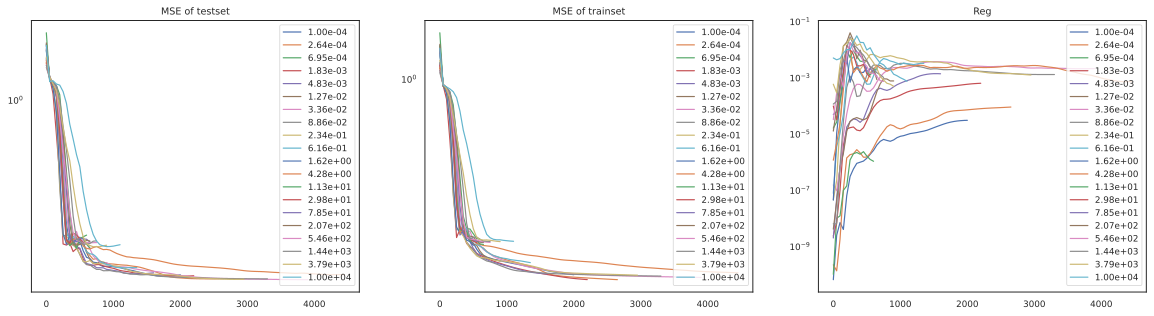

In [22]:
factors = np.logspace(-4, 4, 20)

plt.figure(figsize=(20, 5))

plt.subplot(131)
for idx, df in enumerate(df_reg):
    plt.plot(df.index, df['remaining_MSE_test'], label=f'{factors[idx]:.2e}')
plt.legend()
plt.yscale('log')
plt.title('MSE of testset')

plt.subplot(132)
for idx, df in enumerate(df_reg):
    plt.plot(df.index, df['loss_mse_output_0'], label=f'{factors[idx]:.2e}')
plt.legend()
plt.yscale('log')
plt.title('MSE of trainset')

plt.subplot(133)
for idx, df in enumerate(df_reg):
    plt.plot(df.index, df['loss_reg_output_0'] * factors[idx], label=f'{factors[idx]:.2e}')
plt.legend()
plt.yscale('log')
plt.title('Reg')

In [23]:
est_coeff_keys = natsorted([key for key in df_reg[0].keys() if key[:3] == 'est'])
coeff_keys = natsorted([key for key in df_reg[0].keys() if key[:3] == 'coe'])

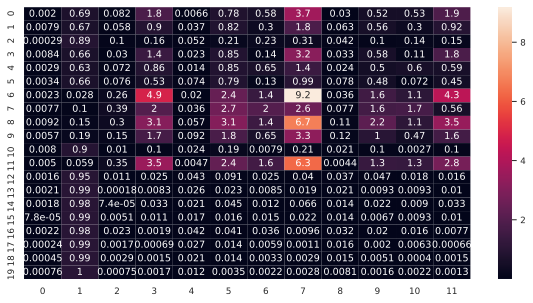

In [24]:
plt.figure(figsize=(10, 5))
sns.heatmap(np.abs(np.concatenate([df[coeff_keys].tail(1).to_numpy() for df in df_reg])), annot=True)

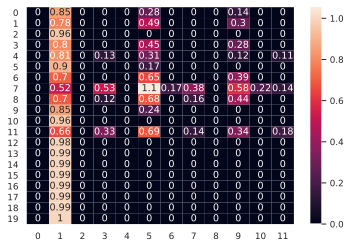

In [25]:
sns.heatmap(np.abs(np.concatenate([df[est_coeff_keys].tail(1).to_numpy() for df in df_reg])), annot=True)

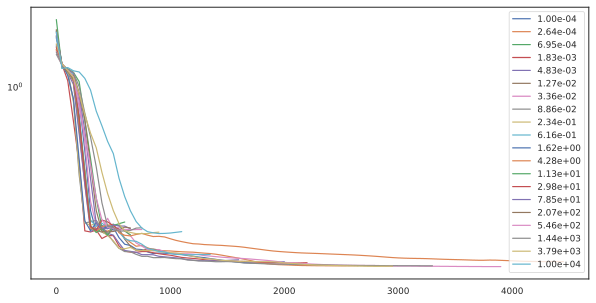

In [28]:
plt.figure(figsize=(10, 5))
for idx, df in enumerate(df_reg):
    plt.plot(df.index, df['remaining_MSE_test'], label=f'{factors[idx]:.2e}')
plt.legend()
plt.yscale('log')

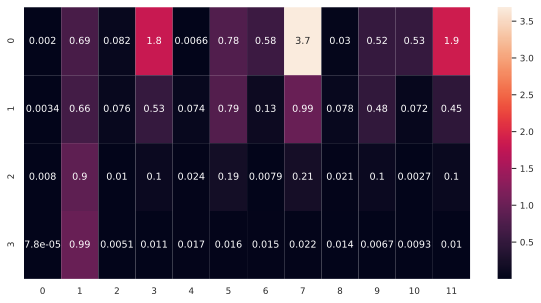

In [29]:
plt.figure(figsize=(10, 5))
sns.heatmap(np.abs(np.concatenate([df[coeff_keys].tail(1).to_numpy() for df in df_reg[::5]])), annot=True)

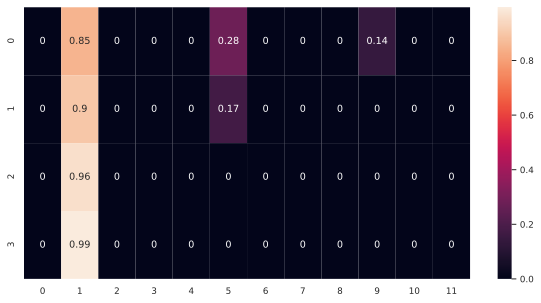

In [30]:
plt.figure(figsize=(10, 5))
sns.heatmap(np.abs(np.concatenate([df[est_coeff_keys].tail(1).to_numpy() for df in df_reg[::5]])), annot=True)

In [62]:
diff = np.abs(np.concatenate([df[est_coeff_keys].tail(1).to_numpy() for df in df_reg[::5]]) - np.concatenate([df[coeff_keys].tail(1).to_numpy() for df in df_reg[::5]]))

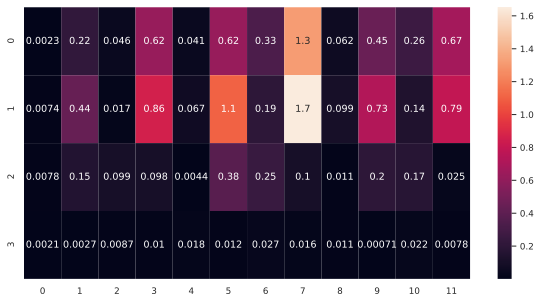

In [63]:
plt.figure(figsize=(10, 5))
sns.heatmap(diff, annot=True)

In [31]:
diff = np.abs(np.concatenate([df[est_coeff_keys].tail(1).to_numpy() for df in df_reg]) - np.concatenate([df[coeff_keys].tail(1).to_numpy() for df in df_reg]))

In [32]:
diff.shape

(20, 12)

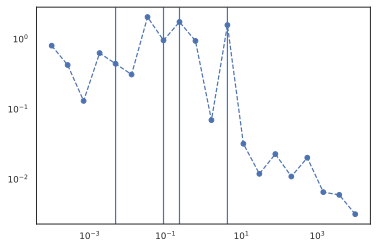

In [38]:
plt.loglog(factors, diff.mean(axis=1), 'o--')
for idx in [4, 7, 8, 11]:
    plt.axvline(factors[idx])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

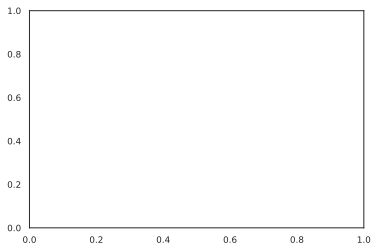

# Analyzing scaling of data

In [70]:
files = natsorted([file for file in listdir('runs') if (file.find('data_scaling') != -1) and (file[-2:] != 'pt')])

In [71]:
files

['Oct27_07-35-10_workstationgjdata_scaling_factor_1.0e-02',
 'Oct27_07-35-48_workstationgjdata_scaling_factor_1.0e-01',
 'Oct27_07-36-25_workstationgjdata_scaling_factor_1.0e+00',
 'Oct27_07-37-02_workstationgjdata_scaling_factor_1.0e+01',
 'Oct27_07-37-39_workstationgjdata_scaling_factor_1.0e+02']

In [72]:
df_scaling = [load_tensorboard(f'runs/{file}') for file in files]

Text(0.5, 1.0, 'Reg')

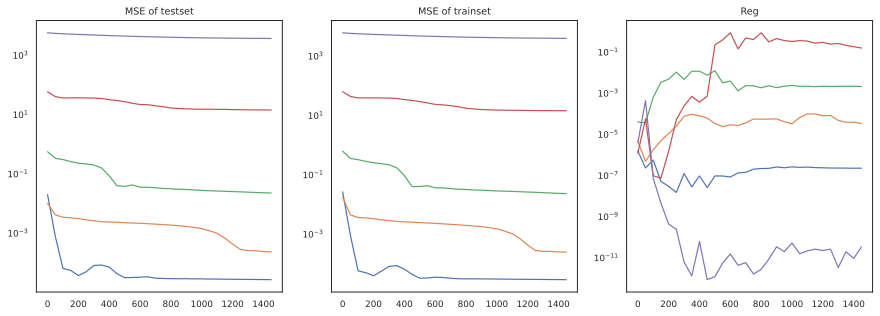

In [73]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
for df in df_scaling:
    plt.plot(df.index, df['remaining_MSE_test'])
plt.yscale('log')
plt.title('MSE of testset')

plt.subplot(132)
for df in df_scaling:
    plt.plot(df.index, df['loss_mse_output_0'])
plt.yscale('log')
plt.title('MSE of trainset')

plt.subplot(133)
for df in df_scaling:
    plt.plot(df.index, df['loss_reg_output_0'])
plt.yscale('log')
plt.title('Reg')

Text(0.5, 1.0, 'Reg')

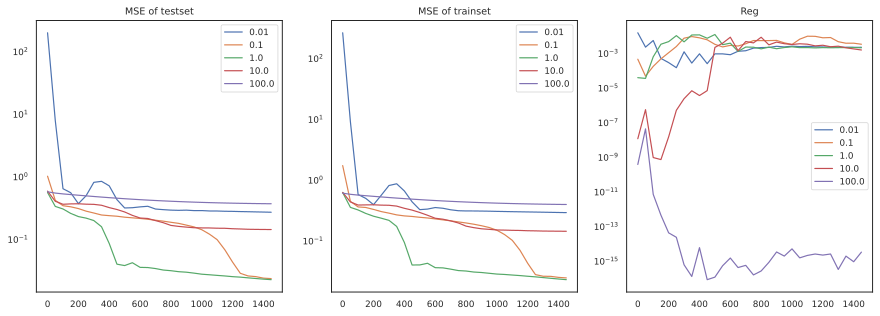

In [87]:
factors = np.logspace(-2, 2, 5)

plt.figure(figsize=(15, 5))

plt.subplot(131)
for idx, df in enumerate(df_scaling):
    plt.plot(df.index, df['remaining_MSE_test'] / factors[idx]**2, label=f'{factors[idx]}')
plt.legend()
plt.yscale('log')
plt.title('MSE of testset')

plt.subplot(132)
for idx, df in enumerate(df_scaling):
    plt.plot(df.index, df['loss_mse_output_0'] / factors[idx]**2, label=f'{factors[idx]}')
plt.legend()
plt.yscale('log')
plt.title('MSE of trainset')

plt.subplot(133)
for idx, df in enumerate(df_scaling):
    plt.plot(df.index, df['loss_reg_output_0'] / factors[idx]**2, label=f'{factors[idx]}')
plt.legend()
plt.yscale('log')
plt.title('Reg')

In [59]:
est_coeff_keys = natsorted([key for key in df_reg[0].keys() if key[:3] == 'est'])
coeff_keys = natsorted([key for key in df_reg[0].keys() if key[:3] == 'coe'])

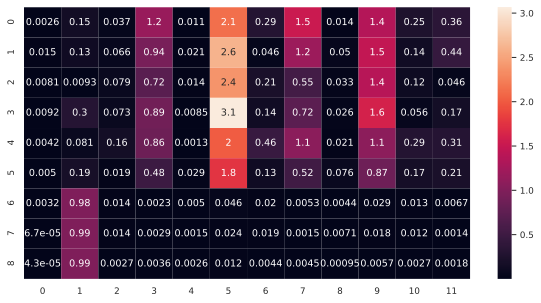

In [64]:
plt.figure(figsize=(10, 5))
sns.heatmap(np.abs(np.concatenate([df[coeff_keys].tail(1).to_numpy() for df in df_reg])), annot=True)

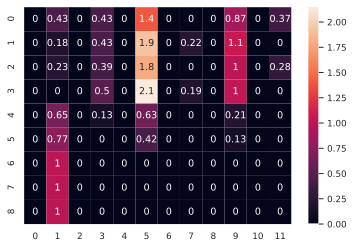

In [65]:
sns.heatmap(np.abs(np.concatenate([df[est_coeff_keys].tail(1).to_numpy() for df in df_reg])), annot=True)